In [22]:
import os
from pathlib import Path
import sys
sys.path.append('../src/')

In [2]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score,\
    roc_curve, roc_auc_score, precision_recall_curve
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

from nn.data_utils import build_transformers, ImgDataset, prep_tvk, \
    build_class_weights, build_targets_mapping, \
    normalize_image
from nn.plotting import show_batch, show_img, DEFAULT_CMAP
from nn.utils import pkl_load, load_checkpoint, get_item, checkpoint
from nn import model_utils

# Remove redundant checkpoints

# Reorganize experiment dumps

# Experiment loading

In [88]:
torch.tensor([1,2]).to(next(model.parameters()).device)

tensor([1, 2], device='cuda:0')

In [3]:
## две очень похожие модели
# 2019_08_16_12_09_41 # old mapping (good wts, rms)
# 2019_08_16_00_47_13 # old mapping (good wts, rms)

# 2019_08_08_10_53_26 (утеряны params, но сетка важная - finetune от 2019_08_07_18_16_02 | 3 канала)
# 2019_08_31_18_06_46 finetuned verion of 2019_08_08_10_53_26

# 2019_08_14_18_44_13 # new mapping (bad wts)
# 2019_08_15_13_56_10 # new mapping (good wts)

# 2019_08_18_17_04_48 # mobilenet classification (first attempt)
# 2019_09_04_16_09_16 # densenet classification 

# 2019_08_17_20_45_50 # mobilenet for eci (new map)

In [4]:
EXPERIMENT_NAME = '2019_09_04_16_09_16'
STAGE = 'f'

os.listdir(f'../checkpoints/{EXPERIMENT_NAME}')

['epoch_50.pt',
 'epoch_60.pt',
 'epoch_f.pt',
 'epoch_40.pt',
 'epoch_20.pt',
 'epoch_0.pt',
 'epoch_30.pt',
 'epoch_90.pt',
 'params.sav',
 'epoch_70.pt',
 'epoch_80.pt',
 'epoch_10.pt']

In [5]:
# load experminet params 

args = pkl_load(f"../checkpoints/{EXPERIMENT_NAME}/params.sav")

MODEL_NAME = args['model']
SINGLE_CHANNEL = not args['triple_channel'] if 'triple_channel' in args else args['single_channel']
tm = args['target_mapping'] if 'target_mapping' in args else None
cw = args['class_weights'] if 'class_weights' in args else None
NEW_MAPPING = not args['old_mapping'] if 'old_mapping' in args else False
CLASSIFICATION = args.setdefault('classify', False)

args

{'seed': 42,
 'workers': 4,
 'model': 'densenet121',
 'optim': 'adam',
 'epochs': 100,
 'batch_size': 32,
 'lr': 0.0001,
 'step': 1,
 'gamma': 0.98,
 'momentum': 0.9,
 'weight_decay': 1e-05,
 'device': device(type='cuda', index=0),
 'checkpoint': '../checkpoints',
 'checkpoint_lp': False,
 'checkpoint_freq': 10,
 'resume': '',
 'pretrained': True,
 'freeze': False,
 'logs_path': '../logs',
 'micro_log': 0,
 'experiment_name': '2019_09_04_16_09_16',
 'data_path': {'train_path': '../data/bin/imgs_merged',
  'val_path': '../data/bin/imgs_merged',
  'tvk_path': '../data/bin/csv/df_tvk_with_pseudo.sav'},
 'img_dir': 'imgs_merged',
 'tvk': 'df_tvk_with_pseudo.sav',
 'build': True,
 'triple_channel': False,
 'old_mapping': True,
 'classify': True,
 'target_column': 'defect',
 'target_mapping': [1, 0],
 'class_weights': array([7.13215890e-05, 1.10778775e-04])}

In [6]:
# init some common vars

is_cuda = torch.cuda.is_available()
print(f"Cuda: {is_cuda}")

TEST = 'test'
VAL = 'val'
SEED = 42
WORKERS = 4
BATCH_SIZE = 32
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = (224, 224)

TRAIN_PATH = VAL_PATH = '../data/bin/imgs/'
TVK_PATH = '../data/bin/csv/05-TvkFiles.sav'

Cuda: True


**TODO:** add df_tvk balancing

In [7]:
df_tvk, target_col = prep_tvk(TVK_PATH,
                              aggregate_categories=NEW_MAPPING,
                              classification=CLASSIFICATION)

if tm is None:
    tm = build_targets_mapping(df_tvk, target_col)

transformer=build_transformers(TEST, IMG_SIZE)
tvk_train, tvk_val = train_test_split(df_tvk, stratify=df_tvk['strata'],
                                      test_size=0.1, random_state=SEED)
dataset = ImgDataset(VAL_PATH, tvk_val, target_col, tm,
                     transform=transformer)
dataset_train = ImgDataset(TRAIN_PATH, tvk_train, target_col, tm,
                           transform=transformer)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                         shuffle=False, drop_last=False, num_workers=WORKERS)

Categories with popultaion < 2: [13]
[DEBUG] Number of missing image files from TVK: 7
[DEBUG] Their names: [10843, 24537, 28366, 2122, 1993, 25344, 25468]
[DEBUG] Number of missing image files from TVK: 79
[DEBUG] Their names: [11386, 3336, 3064, 26033, 10321, 8694, 27521, 8859, 24579, 1984, 10781, 26841, 10374, 2893, 11387, 2428, 2530, 9728, 8846, 1985, 9798, 2138, 2118, 30014, 30273, 11383, 9196, 3050, 9151, 25604, 7655, 2300, 10373, 11385, 30007, 25815, 29986, 7472, 2298, 2556, 7471, 9796, 3048, 27880, 23628, 11126, 7659, 10877, 2141, 3063, 7767, 8852, 9799, 24105, 2552, 9505, 10292, 22993, 5405, 8865, 9136, 11384, 30271, 2140, 24723, 7766, 24180, 3056, 5261, 25446, 10370, 10842, 25709, 23729, 25318, 8847, 24934, 25683, 2553]


In [8]:
# маппинг таргетов
n_classes = len(tm)
tm

[1, 0]

In [9]:
# кол-во элементов в классах
if cw is None:
    cw = build_class_weights(dataset_train)
1/cw

array([14021.,  9027.])

In [10]:
model = model_utils.ModelBuilder((1,224,224), n_classes, model_name=MODEL_NAME,
                                 single_channel=SINGLE_CHANNEL, device=DEVICE)

# загрузим предобученную модель
load_checkpoint(f"../checkpoints/{EXPERIMENT_NAME}/epoch_{STAGE}.pt", model, None, device=DEVICE)

[DEBUG] Loaded model wts from epoch #100


## правка classification слоя

## в тест режим

In [11]:
model.eval()
for param in model.parameters():
    param.requires_grad = False

# Mapping load

In [18]:
def drop_low_categories(df, target_column):
    """Функция убирает категории оборудования с малым кол-вом данных (меньше `threshold`)"""

    threshold = 2
    cat_cnt = df[target_column].value_counts()
    cat_cnt_low = cat_cnt[cat_cnt < threshold]
    print("Categories with popultaion < "
          f"{threshold}: {cat_cnt_low.index.values}")
    return df[~df[target_column].isin(cat_cnt_low.index)]

def load_mapping(path, sheet_name):
    df = pd.read_excel(path, sheet_name=sheet_name)
    # берем только крупные категории
    df = df.loc[df['count'] >= 100, :].astype(str)
    return df

def parse_mapping(df: pd.DataFrame):
    """Парсит df_mapping raw в удобный формат:
    tuple(equipment_id, equipment_element_id, equipment_name, equipment_element_name, new_class)
    """

    return [(int(ec_i), int(eec_i), ec_name, eec_name, idx)
            for idx, row in df.iterrows()
            for ec_i, eec_i, ec_name, eec_name in zip(row.equipment_category_id.split(','),
                                                      row.equipment_element_category_id.split(','),
                                                      row.equipment.split(','),
                                                      row.part_equipment.split(','))
            ]

def collect_df(parsed_mapping):
    """Собирает DataFrame из парсинга"""

    return (pd
            .DataFrame(parsed_mapping, columns=['equipment_category_id', 'equipment_element_category_id',
                                                'equipment', 'part_equipment', 'class'])
            .drop_duplicates()
            .set_index(['equipment_category_id', 'equipment_element_category_id'])
            )

def map2class(x):
    """Лямбда для маппинга"""

    if x.equipment_category_id in df_mapping.index.levels[0]:
        if x.equipment_element_category_id in df_mapping.loc[x.equipment_category_id].index:
            classes = df_mapping.loc[x.equipment_category_id].loc[x.equipment_element_category_id, 'class']
            classes = np.unique(classes)
            if len(classes) > 1:
                raise ValueError("Нужен маппинг 1 к 1.")
            return classes[0]
    return np.nan
    
df_mapping_raw = load_mapping(path='../data_/Контрольные узлы_группы.xlsx', sheet_name='Union')
mapping = parse_mapping(df_mapping_raw)
df_mapping = collect_df(mapping)

In [20]:
df_mapping_raw

count                                          equipment  \
0   7139  ВЛ,шины,гирлянда,изолятор подвесной,высокочаст...   
1   2560  разъединитель,трансформатор тока,ввод,разъедин...   
2   1071                                 изолятор проходной   
3   1018                           разъединитель,отделитель   
4    586            шины, ВЛ,контактное соединение проводов   
5    459                              силовой трансформатор   
6    401       кабель силовой,кабель силовой,кабель силовой   
7    390   разрядник вентильный,ограничитель перенапряжений   
8    264                        высокочастотный заградитель   
9    229                                      разъединитель   
10   222  разъединитель,изолятор опорный,изолятор опорны...   
11   215    ВЛ,шины,контактное соединение проводов,ВЛ,ВЛ,ВЛ   
12   214                                               ввод   
13   210                                     кабель силовой   
14   207                              силовой трансформатор   
15   180                               масляный выключатель   
16   170                                     кабель силовой   
17   162                   КРУ и КРУН,КРУ и КРУН,КРУ и КРУН   
18   145                              силовой трансформатор   
19   140                           трансформатор напряжения   
20   126                                 изолятор проходной   

                                       part_equipment  \
0   гирлянда,гирлянда,изолятор,поверхность фарфора...   
1   контактное соединение: разъединитель - шина,ко...   
2                               контактное соединение   
3           контакт: губки - нож,контакт: губки - нож   
4   болтовое контактное соединение, Болтовые конта...   
5                              часть поверхности бака   
6   изоляция жилы кабеля,изоляция жил кабеля,изоля...   
7            фарфоровая покрышка,поверхность покрышки   
8                        нижнее контактное соединение   
9                      подвижное шарнирное соединение   
10  поверхность фарфора опорного изолятора,поверхн...   
11  Контактные соединения; выполненные скруткой,ко...   
12                                фарфоровая покрышка   
13            контактное соединение: жила кабеля-шина   
14                                 система охлаждения   
15                                    бак выключателя   
16                 болтовое присоединение жилы кабеля   
17  нижний втычной контакт,контактное соединение: ...   
18                 поверхность термосифонного фильтра   
19                                фарфоровая покрышка   
20                                поверхность фарфора   

         equipment_category_id              equipment_element_category_id  \
0                17,24,24,24,8                          75,114,113,114,12   
1   1,3,7,1,9,9,6,9,9,9,4,12,4  96,137,5,199,20,20,60,20,20,20,119,60,119   
2                           30                                         43   
3                         1,19                                      97,89   
4                    24, 17,24                                117, 74,117   
5                            2                                        124   
6                     11,11,11                                   50,50,51   
7                        21,16                                      90,73   
8                            8                                         10   
9                            1                                         98   
10               1,29,29,29,19                             95,37,37,37,86   
11           17,24,24,17,17,17                        80,116,116,77,83,82   
12                           7                                          9   
13                          11                                         52   
14                           2                                        133   
15                           9                                         14   
16                          11                      

In [21]:
# меппинг на названия классов

df_eci = pd.read_pickle('../data/bin/csv/01-EquipmentCategories.sav').set_index('id')
df_eci

name
id                             
1                 Разъединитель
2         Трансформатор силовой
3            Трансформатор тока
4      Трансформатор напряжения
5                           АКБ
6                           БСК
7                          Ввод
8                           ВЧЗ
9                   Выключатель
10         Выключатель нагрузки
11              Кабельная линия
12            Конденсатор связи
13            Короткозамыкатель
14                   ячейка КРУ
15                         КРУЭ
16                          ОПН
17                     Опора ВЛ
18                   Пролеты ВЛ
19                   Отделитель
20              предохранитель 
21         Разрядник вентильный
22          Реактор дугогосящий
23   Реактор токоограничивающий
24                  Система шин
25  Автоматический  выключатель
26                   Рубильник 
27    Оборудование РУ до 1000 В
28       Оборудование РЗА и ПА 
29             Изолятор опорный
30           Изолятор проходной

In [22]:
# сколько этих разрядников?

(tvk_train.equipment_category_id == 21).sum(), (tvk_val.equipment_category_id == 21).sum()

(318, 35)

In [23]:
# берем пример

_img_num = 1004
tvk_train[tvk_train.id == _img_num]

id  id_measuring  id_disp  equipment_category_id  \
419  1004            44   3369.0                      2   

     equipment_element_category_id  defect_stage  id_palette   file_thermo  \
419                            124           2.0          26  I0001000.029   

           file_photo phase  ... arrow_photo temp_b  temp_c  temp_air  repair  \
419  125-2574_IMG.JPG   NaN  ...         NaN    NaN     NaN       NaN     NaN   

     date_repair  temp_a calc_temp  text_thermo strata  
419          NaN     NaN       NaN          NaN    2_1  

[1 rows x 34 columns]

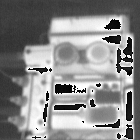

In [24]:
# истиное изображение

_img = pkl_load(f'../data/bin/imgs/{_img_num}.sav')
to_pil_image(normalize_image(_img))

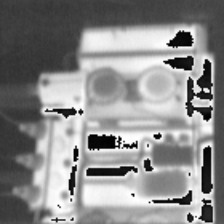

In [25]:
# где он в датасете

_df = dataset_train.tvk
(x, _), y = dataset_train[_df[_df.id == _img_num].index.item()]
if is_cuda:
    x = x.cuda()

to_pil_image(x.cpu())

In [26]:
# выбираем маппинг

_tmp = df_eci.copy()

In [31]:
y_hat = model(x.unsqueeze(0))
_proba, _class = y_hat.softmax(1).topk(5)

_locs = [dataset.decode_label(p.item()) for p in _class[0, :]]
_tmp.loc[_locs, 'proba'] = _proba.detach().cpu().squeeze().numpy()
_tmp.loc[_locs]

KeyError: '[0] not in index'

VAL transformer

In [22]:
y_hat = model(x.unsqueeze(0))
_proba, _class = y_hat.softmax(1).topk(5)

_locs = [dataset.decode_label(p.item()) for p in _class[0, :]]
_tmp.loc[_locs, 'proba'] = _proba.detach().cpu().squeeze().numpy()
_tmp.loc[_locs]

name     proba
id                                 
2   Трансформатор силовой  0.999983
24            Система шин  0.000005
7                    Ввод  0.000004
1           Разъединитель  0.000003
8                     ВЧЗ  0.000002

# Classify all

In [12]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [106]:
%%time

# predict labels

_pred, _pred_proba, _pred_class = [], [], []
_inputs, _targets = [], []
_filenames = []

for (inputs, filenames), targets in data_loader:
    if is_cuda:
        inputs = inputs.cuda()
        targets = targets.cuda()
    
    pred = model(inputs).softmax(1)
    pred_proba, pred_class = pred.max(1)
    
    if is_cuda:
        inputs = inputs.cpu()
        targets = targets.cpu()
        pred, pred_proba, pred_class = pred.cpu(), pred_proba.cpu(), pred_class.cpu()
        
    _pred.append(pred)
    _pred_proba.append(pred_proba)
    _pred_class.append(pred_class)
    _inputs.append(inputs)
    _targets.append(targets)
    _filenames.append(filenames)

# squeeezing
pred = torch.cat(_pred)
pred_proba = torch.cat(_pred_proba)
pred_class = torch.cat(_pred_class)
inputs = torch.cat(_inputs)
targets = torch.cat(_targets)
filenames = flatten(_filenames)

CPU times: user 11.7 s, sys: 2.1 s, total: 13.8 s
Wall time: 16.9 s


CPU:
    - eci: 33 min
    - defects: 33 min

GPU:
    - eci: 4.8s - mobilenet | 13.8s - densenet
    - defects: 21.3s - densenet

In [14]:
# tensor shapes

inputs.shape, targets.shape, pred.shape

(torch.Size([1715, 1, 224, 224]), torch.Size([1715]), torch.Size([1715, 2]))

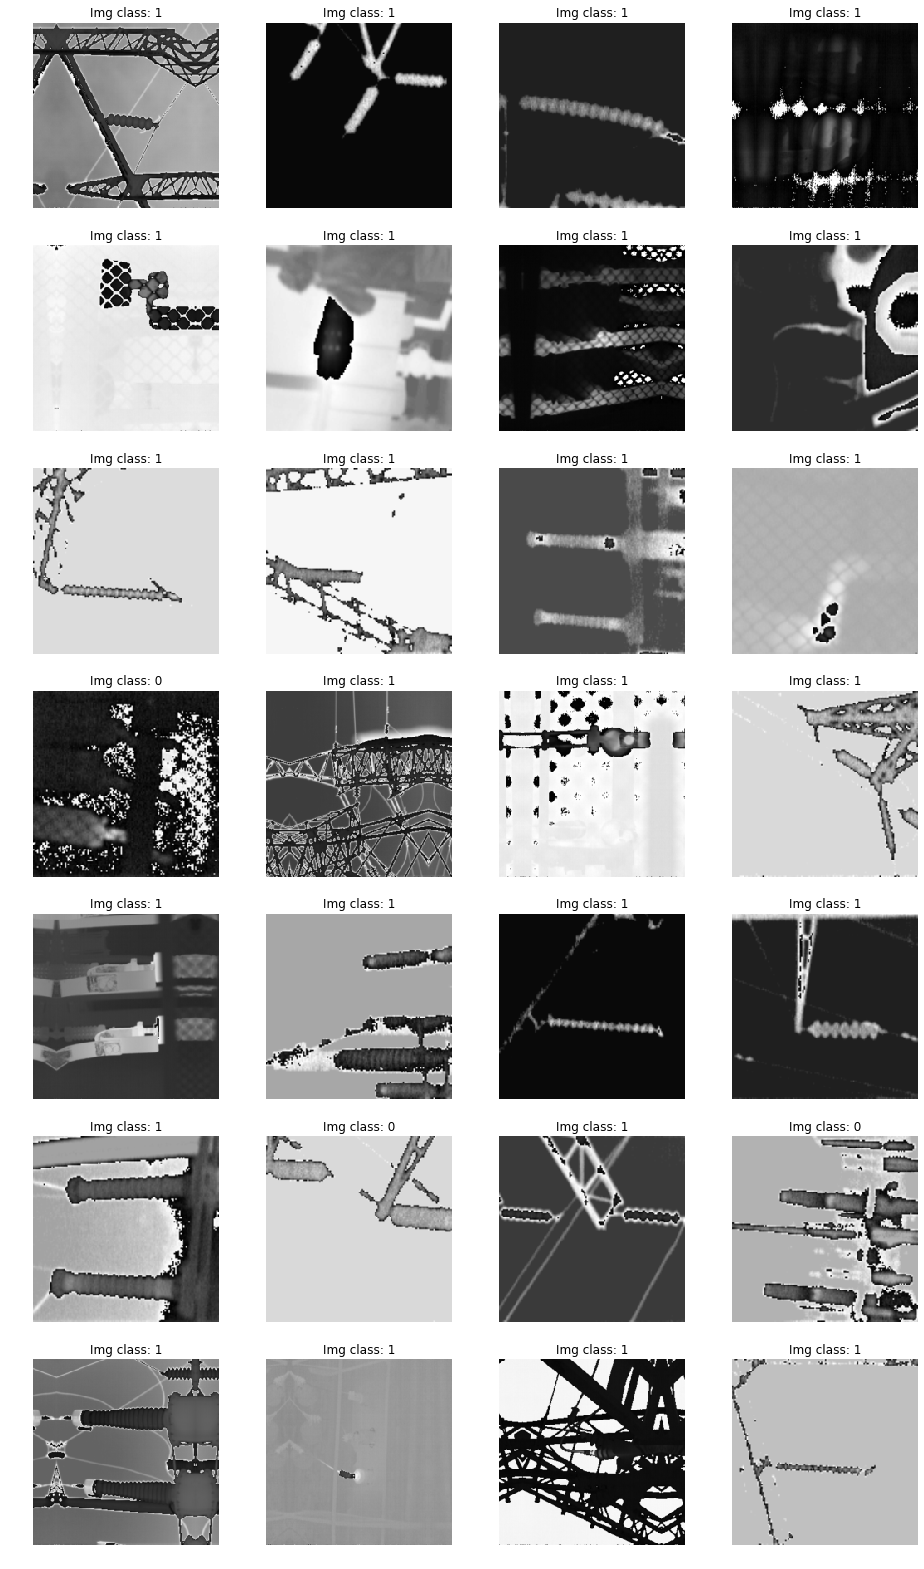

In [15]:
show_batch(inputs[0:30],
           [f"Img class: {dataset.decode_label(t)}" for t in targets.tolist()],
           fig_scale=4, cmap='gray')

# Probas Plotting

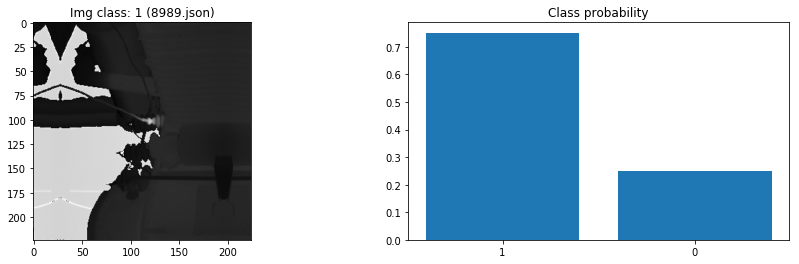

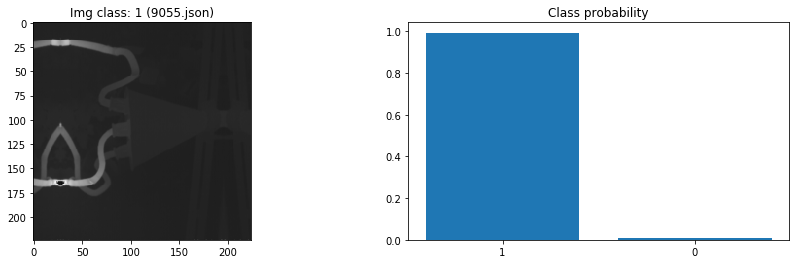

In [17]:
# код на построение графика: картинка - вероятности

N_IMAGES_TO_SHOW = 2

idx = 0
for img, y, y_hat_proba, y_hat_class, file_source in zip(inputs, targets,
                                                         pred, pred_class, filenames):

    if y == y_hat_class:
        fig, axs = plt.subplots(1, 2, figsize=(15, 4))

        # картинка
        axs[0].set_title(
            f"Img class: {dataset.decode_label(y)} ({file_source.split('.')[0]}.json)")
        axs[0].imshow(to_pil_image(img), cmap='gray')

        # вероятности
        axs[1].set_title('Class probability')
        i = np.arange(0, n_classes)
        axs[1].bar(i, y_hat_proba)
        plt.xticks(i, dataset.targets)

        # рисуем
        plt.show()

        idx += 1

    if idx == N_IMAGES_TO_SHOW:
        break

In [18]:
# меппинг на названия классов

df_eq = pd.read_pickle('../data/bin/01-EquipmentCategories.sav').set_index('id')
[df_eq.loc[t].item() for t in tm]

KeyError: 0

In [20]:
# выборочная проверка файла
df_tvk[df_tvk.id==8989]

id  id_measuring  id_disp  equipment_category_id  \
7326  8989           381   4865.0                      7   

      equipment_element_category_id  defect_stage  id_palette   file_thermo  \
7326                              5           4.0          26  TH910193.SIT   

     file_photo   phase  ... temp_b temp_c  temp_air  repair  date_repair  \
7326        NaN  правая  ...    NaN    NaN       NaN     NaN          NaN   

      temp_a  calc_temp text_thermo  agg_class strata  
7326     NaN        NaN         NaN          1    1_1  

[1 rows x 35 columns]

# Scoring

In [16]:
mpd_targets = np.array([dataset.decode_label(t) for t in targets])
mpd_pred_class = np.array([dataset.decode_label(t) for t in pred_class])

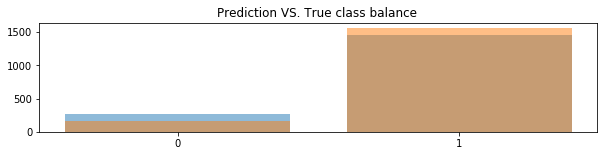

In [17]:
plt.figure(figsize=(10, 2))
plt.title("Prediction VS. True class balance ")
plt.bar(*np.unique(mpd_pred_class, return_counts=1), alpha=0.5)
plt.bar(*np.unique(mpd_targets, return_counts=1), alpha=0.5)
plt.xticks(np.unique(mpd_pred_class))
plt.show()

## Classification

In [107]:
# классификация

print("Precision: {:>5.3}\nRecall: {:>8.3}\nF1: {:>11.3}".format(
    precision_score(mpd_targets, mpd_pred_class),
    recall_score(mpd_targets, mpd_pred_class),
    f1_score(mpd_targets, mpd_pred_class)))

Precision: 0.949
Recall:    0.885
F1:       0.916


In [108]:
# подготовим данные по которым будем считать внутриклассовую точность

df_test = df_tvk.set_index('id').loc[np.array([int(fname.split('.sav')[0])
                                               for fname in filenames])]

df_test.head()

id_measuring  id_disp  equipment_category_id  \
id                                                    
29865          1592  13226.0                     17   
24900          1502  11834.0                     17   
26839          1530  12424.0                     17   
11228          1872   4419.0                     30   
1710            138   4480.0                      3   

       equipment_element_category_id  defect_stage  id_palette   file_thermo  \
id                                                                             
29865                             75           2.0          26  TH910125.SIT   
24900                             75           2.0          26  I0001300.052   
26839                             75           2.0          26  I0003800.020   
11228                             43           4.0          26  TH910046.SIT   
1710                             137           4.0          26  TH910043.SIT   

             file_photo       phase       side  ... arrow_photo  temp_b  \
id                                              ...                       
29865               NaN           С        NaN  ...         NaN     NaN   
24900               NaN  С, Н, ПОДВ          5  ...         NaN     NaN   
26839               NaN       ОБВ Л        NaN  ...         NaN     NaN   
11228      TH910046.jpg      правая        NaN  ...         NaN     NaN   
1710   137-3734_IMG.JPG           К  нижнее кс  ...         NaN     NaN   

       temp_c  temp_air  repair  date_repair temp_a  calc_temp text_thermo  \
id                                                                           
29865     NaN       NaN     NaN          NaN    NaN        NaN         NaN   
24900     NaN       NaN     NaN          NaN    NaN        NaN         NaN   
26839     NaN       NaN     NaN          NaN    NaN        NaN         NaN   
11228     NaN       NaN     NaN          NaN    NaN        NaN         NaN   
1710      NaN       NaN     NaN          NaN    NaN        NaN         NaN   

      strata  
id            
29865   17_1  
24900   17_1  
26839   17_1  
11228   30_1  
1710     3_1  

[5 rows x 33 columns]

In [109]:
# классификация

_class_metrics = []
for eci in df_test.equipment_category_id.unique():
    _class_mask = np.where(df_test.equipment_category_id == eci)[0]
    _p = precision_score(mpd_targets[_class_mask], mpd_pred_class[_class_mask])
    _r = recall_score(mpd_targets[_class_mask], mpd_pred_class[_class_mask])
    _f1 = f1_score(mpd_targets[_class_mask], mpd_pred_class[_class_mask])
    _class_metrics.append([eci, _p, _r, _f1])
_class_metrics = np.array(_class_metrics)
_class_metrics

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[17.        ,  0.98953662,  0.95251799,  0.97067449],
       [30.        ,  0.91176471,  0.86915888,  0.88995215],
       [ 3.        ,  0.95945946,  0.97260274,  0.96598639],
       [ 2.        ,  0.83333333,  0.6557377 ,  0.73394495],
       [ 1.        ,  0.92410714,  0.87341772,  0.89804772],
       [ 7.        ,  0.85106383,  0.58823529,  0.69565217],
       [21.        ,  0.90909091,  0.625     ,  0.74074074],
       [ 9.        ,  0.91489362,  0.91489362,  0.91489362],
       [10.        ,  1.        ,  0.75      ,  0.85714286],
       [29.        ,  1.        ,  0.4       ,  0.57142857],
       [ 4.        ,  0.88888889,  0.53333333,  0.66666667],
       [11.        ,  0.95121951,  0.93975904,  0.94545455],
       [24.        ,  0.92727273,  0.89473684,  0.91071429],
       [ 8.        ,  0.80555556,  0.78378378,  0.79452055],
       [14.        ,  1.        ,  1.        ,  1.        ],
       [19.        ,  0.        ,  0.        ,  0.        ],
       [ 5.        ,  1.

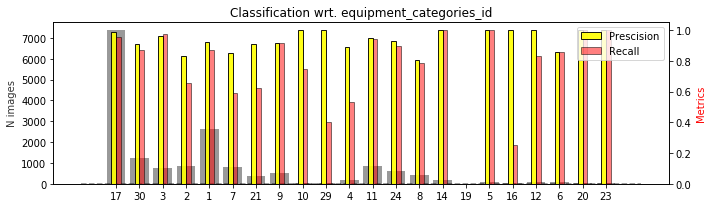

In [110]:
_bar_width = 0.2
_bias = _bar_width / 2

plt.figure(figsize=(10, 3))
plt.title("Classification wrt. equipment_categories_id")

# plot n images
_img_count = df_tvk.equipment_category_id.value_counts()
plt.bar(np.arange(0, len(_class_metrics)),
        _img_count.loc[_class_metrics[:, 0].astype(int)].values,
        color='gray', alpha=0.8)
plt.xticks(np.arange(0, len(_class_metrics)), _class_metrics[:, 0].astype(int))
plt.ylabel("N images", color='black', alpha=0.8)
plt.hlines(0.5, *plt.xlim(), linestyle='--', alpha=0.5)

plt.twinx()
# plot metrics
plt.bar(np.arange(0, len(_class_metrics))-_bias, _class_metrics[:, 1],
        width=_bar_width, edgecolor='black', color='yellow', alpha=0.9)
plt.bar(np.arange(0, len(_class_metrics))+_bias, _class_metrics[:, 2],
        width=_bar_width, edgecolor='black', color='red', alpha=0.5)
plt.legend(["Prescision", "Recall"])
plt.ylabel("Metrics", color='red')

plt.tight_layout()
plt.show()

In [111]:
target_eq_one_pos = np.where(np.array(tm)==1)[0][0]

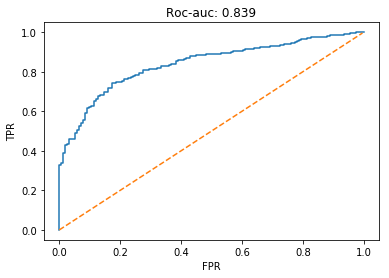

In [112]:
fpr, tpr, thresholds = roc_curve(mpd_targets, pred[:, target_eq_one_pos])

plt.title(f"Roc-auc: {roc_auc_score(mpd_targets, pred[:, target_eq_one_pos]):.3f}")
plt.plot(fpr, tpr)
plt.plot(np.arange(0, 1, step=1/len(thresholds)),
         np.arange(0, 1, step=1/len(thresholds)),
         linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

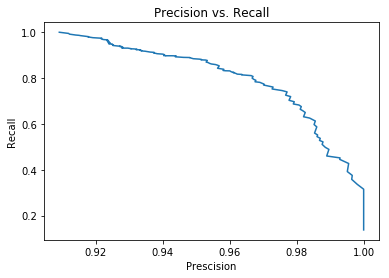

In [113]:
pr_scores = np.array([(precision_score(mpd_targets, pred[:, target_eq_one_pos] > th),
                       recall_score(mpd_targets, pred[:, target_eq_one_pos] > th),
                       th)
                      for th in np.arange(0, 1, 0.005)])
plt.title("Precision vs. Recall")
plt.plot(pr_scores[:, 0], pr_scores[:, 1])
plt.xlabel("Prescision")
plt.ylabel("Recall")
plt.show()

In [114]:
# choosing PR at leas higher than `TH`

TH = 0.9
# prescision, recall, threshold
_pr_pos, _rc_pos = 0, 1
print("Prescision: \t{:.3f}\nRecall: \t{:.3f}\nThreshold: \t{:.3f}".format(*pr_scores[np.where(pr_scores[:, _rc_pos] > TH)[0][-1]]))

Prescision: 	0.940
Recall: 	0.902
Threshold: 	0.435


In [32]:
# new сетка со взвешиванием

print("Precision: {:>5.3}\nRecall: {:>8.3}\nF1: {:>11.3}".format(
    precision_score(targets, pred_class, average='weighted'),
    recall_score(targets, pred_class, average='weighted'),
    f1_score(targets, pred_class, average='weighted')))

Precision:  0.67
Recall:    0.641
F1:       0.637


In [56]:
# new сетка без взвешивания

print("Precision: {:>5.3}\nRecall: {:>8.3}\nF1: {:>11.3}".format(
    precision_score(targets, pred_class, average='weighted'),
    recall_score(targets, pred_class, average='weighted'),
    f1_score(targets, pred_class, average='weighted')))

Precision:  0.85
Recall:    0.763
F1:        0.79


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Precision plot

## v1

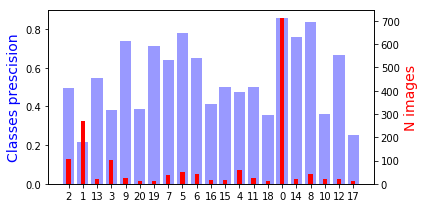

In [48]:
i = np.arange(0, n_classes)

fig, ax = plt.subplots(figsize=(6, 3))

fs = 14
c = 'blue'
ax.set_ylabel("Classes prescision", color=c, fontsize=fs)
ax.bar(i, precision_score(targets, pred_class, average=None),
       color=c, alpha=0.4)

c = 'red'
ax_ = ax.twinx()
ax_.set_ylabel("N images", color=c, fontsize=fs)
ax_.bar(*np.unique(targets.numpy(), return_counts=True),
        color = c, width=0.3)

plt.xticks(i, dataset.targets)
fig.tight_layout()
plt.show()

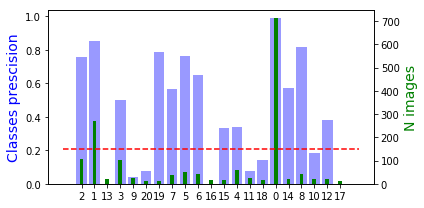

In [60]:
# сетка без коррекцией весов

i = np.arange(0, n_classes)

fig, ax = plt.subplots(figsize=(6, 3))

fs = 14
c = 'blue'
ax.set_ylabel("Classes prescision", color=c, fontsize=fs)
ax.bar(i, precision_score(targets, pred_class, average=None),
       color=c, alpha=0.4)

c = 'green'
ax_ = ax.twinx()
ax_.set_ylabel("N images", color=c, fontsize=fs)
ax_.bar(i, cw*len(dataset),
        color = c, width=0.3)
ax_.hlines(150, *ax_.get_xlim(), linestyle='--', color='red')

plt.xticks(i, dataset.targets)
fig.tight_layout()
plt.show()

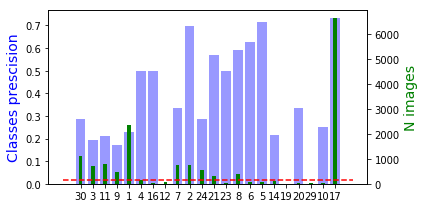

In [42]:
# old сетка с коррекцией весов

i = np.arange(0, n_classes)

fig, ax = plt.subplots(figsize=(6, 3))

fs = 14
c = 'blue'
ax.set_ylabel("Classes prescision", color=c, fontsize=fs)
ax.bar(i, precision_score(targets, pred_class, average=None),
       color=c, alpha=0.4)

c = 'green'
ax_ = ax.twinx()
ax_.set_ylabel("N images", color=c, fontsize=fs)
ax_.bar(i, 1/cw, 
        color = c, width=0.3)
ax_.hlines(150, *ax_.get_xlim(), linestyle='--', color='red')

plt.xticks(i, dataset.targets)
fig.tight_layout()
plt.show()

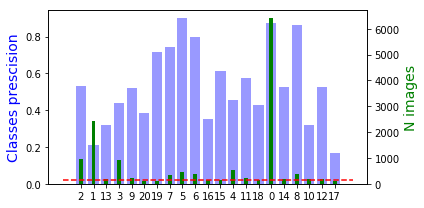

In [31]:
# сетка с коррекцией весов

i = np.arange(0, n_classes)

fig, ax = plt.subplots(figsize=(6, 3))

fs = 14
c = 'blue'
ax.set_ylabel("Classes prescision", color=c, fontsize=fs)
ax.bar(i, precision_score(targets, pred_class, average=None),
       color=c, alpha=0.4)

c = 'green'
ax_ = ax.twinx()
ax_.set_ylabel("N images", color=c, fontsize=fs)
ax_.bar(i, 1/cw, 
        color = c, width=0.3)
ax_.hlines(150, *ax_.get_xlim(), linestyle='--', color='red')

plt.xticks(i, dataset.targets)
fig.tight_layout()
plt.show()

## v2

### mobilenet с коррекцией весов AGGREGATED

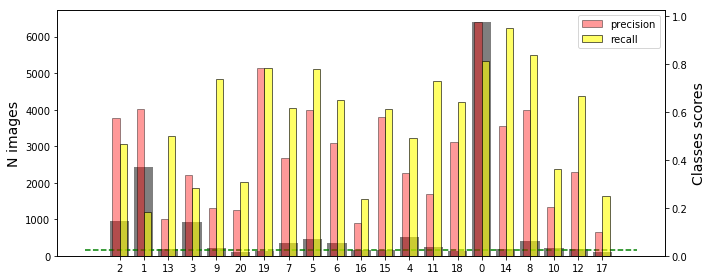

In [57]:
i = np.arange(0, n_classes)

fig, ax = plt.subplots(figsize=(10, 4))
fs = 14

c = 'black'
ax.set_ylabel("N images", color=c, fontsize=fs)
ax.bar(i, 1/cw,
       color=c, width=0.8, alpha=0.5)
ax.hlines(150, *ax.get_xlim(), linestyle='--', color='green')

ax_ = ax.twinx()

ax_.set_ylabel("Classes scores", fontsize=fs)
ax_.bar(i - 0.15, precision_score(targets, pred_class, average=None), 0.3,
        color='red', alpha=0.4, edgecolor='black')

ax_.bar(i + 0.15, recall_score(targets, pred_class, average=None), 0.3,
        color='yellow', alpha=0.6, edgecolor='black')
ax_.legend(['precision', 'recall'])
# ax_.set_ylim(0.5, 1)

plt.xticks(i, dataset.targets)
fig.tight_layout()
plt.show()

### densenet с коррекцией весов ECI

In [ ]:
i = np.arange(0, n_classes)

fig, ax = plt.subplots(figsize=(10, 4))
fs = 14

c = 'black'
ax.set_ylabel("N images", color=c, fontsize=fs)
ax.bar(i, 1/cw,
       color=c, width=0.8, alpha=0.5)
ax.hlines(150, *ax.get_xlim(), linestyle='--', color='green')

ax_ = ax.twinx()

ax_.set_ylabel("Classes scores", fontsize=fs)
ax_.bar(i - 0.15, precision_score(targets, pred_class, average=None), 0.3,
        color='red', alpha=0.4, edgecolor='black')

ax_.bar(i + 0.15, recall_score(targets, pred_class, average=None), 0.3,
        color='yellow', alpha=0.6, edgecolor='black')
ax_.legend(['precision', 'recall'])
# ax_.set_ylim(0.5, 1)

plt.xticks(i, dataset.targets)
fig.tight_layout()
plt.show()

In [31]:
_a = np.array([1/cw, dataset.targets, precision_score(targets, pred_class, average=None)]).T

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
df_precision = pd.DataFrame(_a, columns=['number_images_on_estimation',
                                        'equipment_category_id',
                                        'precision']).set_index('equipment_category_id')
df_precision.to_csv('df_precision.csv')

# Proxy for quality increase

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


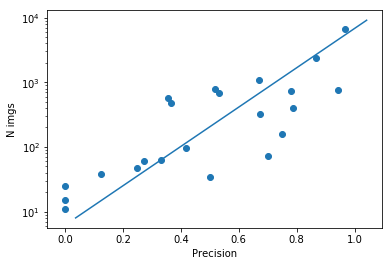

In [28]:
from sklearn.linear_model import LinearRegression

X = np.log(1/cw+1e-8)
y = precision_score(targets, pred_class, average=None)
lm = LinearRegression(fit_intercept=True).fit(X.reshape(-1,1),y)

plt.scatter(precision_score(targets, pred_class, average=None), 1/cw)
plt.xlabel('Precision')
plt.ylabel('N imgs')
plt.yscale('log')

_x1, _x2 = plt.ylim()
plt.plot(lm.predict(np.log(np.array([_x1, _x2]).reshape(-1,1))),
         np.array([_x1, _x2]))
plt.show()

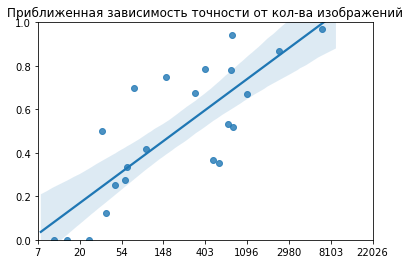

In [44]:
import seaborn as sns

plt.title('Приближенная зависимость точности от кол-ва изображений')
sns.regplot(np.log(1/cw+1e-8), precision_score(targets, pred_class, average=None))
_xt = plt.xticks()[0]
plt.xticks(_xt, np.exp(_xt).astype(int))
plt.ylim(0,1)
plt.show()

# Classify all & save result

In [102]:
with open('./correct.txt', 'w') as f:
    f.writelines('\n'.join([filename.replace('.sav', '') 
                  for filename, _passed
                  in zip(filenames, (targets == pred_class).tolist())
                  if _passed]))

In [103]:
with open('./incorrect.txt', 'w') as f:
    f.writelines('\n'.join([filename.replace('.sav', '') 
                  for filename, _passed
                  in zip(filenames, (targets != pred_class).tolist())
                  if _passed]))

# Тест на новых изображениях

In [18]:
def parse_arrays(array_json):
    parsed_imgs_array = []
    for x in array_json:
        img = np.array(x["tempArray"])
        h, w = img.shape
        if h < 64 or w < 64:
            raise ValueError("Img should size be not lower than (64 x 64)")
        parsed_imgs_array.append(to_pil_image(normalize_image(img)))
    return parsed_imgs_array

In [19]:
# проиндексируем изображения
path = '../data/bin/imgs_unclassified/'
imgs_idx = os.listdir(path)
len(imgs_idx)

8479

## Create pseudo tvk

In [110]:
df_tvk_current = pd.read_pickle(f"{args['data_path']['tvk_path'].replace('/bin', '/bin/csv')}")
df_tvk_current.head()

id  id_measuring  id_disp  equipment_category_id  \
0  343            12   4066.0                     30   
1  344            14   3193.0                      3   
2  345            13   3193.0                      3   
3  346            15   3193.0                      3   
4  347            15   3193.0                     11   

   equipment_element_category_id  defect_stage  id_palette   file_thermo  \
0                             43           4.0          26  TH910009.SIT   
1                            137           3.0          26  I0008900.008   
2                            137           3.0          26  I0001600.002   
3                            137           3.0          26  TH910018.SIT   
4                             56           3.0          26  TH910018.SIT   

         file_photo phase  ... arrow_thermo arrow_photo  temp_b  temp_c  \
0  142-4293_IMG.JPG     К  ...          NaN         NaN     NaN     NaN   
1               NaN     Ж  ...          NaN         NaN     NaN     NaN   
2  113-1323_IMG.JPG     Ж  ...          NaN         NaN     NaN     NaN   
3  131-3185_IMG.JPG     Ж  ...          NaN         NaN     NaN     NaN   
4  131-3185_IMG.JPG     З  ...          NaN         NaN     NaN     NaN   

   temp_air  repair  date_repair temp_a calc_temp text_thermo  
0       NaN     NaN          NaN    NaN       NaN         NaN  
1       NaN     NaN          NaN    NaN       NaN         NaN  
2       NaN     NaN          NaN    NaN       NaN         NaN  
3       NaN     NaN          NaN    NaN       NaN         NaN  
4       NaN     NaN          NaN    NaN       NaN         NaN  

[5 rows x 33 columns]

In [111]:
_a = np.array([imgs_idx, np.ones(len(imgs_idx))*-1, np.zeros(len(imgs_idx))]).T
df_pseudo_tvk = pd.DataFrame(_a, columns=['id', 'equipment_category_id', 'defect_stage'])
# df_pseudo_tvk['id'] = df_pseudo_tvk.id.replace("[|]", "/", regex=True).replace('.sav', '', regex=True)
df_pseudo_tvk['id'] = df_pseudo_tvk.id.replace('.sav', '', regex=True)
df_pseudo_tvk.to_csv('tvk_pseudo.csv')
df_pseudo_tvk.head()

id equipment_category_id defect_stage
0    Термо ПС|Малахово|T03793IR                  -1.0          0.0
1  Термо ПС|Знаменская|T03285IR                  -1.0          0.0
2      Термо ПС|Волово|T01212IR                  -1.0          0.0
3     Термо ПС|Задонье|T04463IR                  -1.0          0.0
4   Термо ПС|Оленьково|T04874IR                  -1.0          0.0

In [112]:
df_new.defect_stage.value_counts().values

array([8918, 8480, 4277, 2464, 1541])

In [113]:
# save stacked DF
df_new =  df_tvk_current.append(df_pseudo_tvk, sort=False)
df_new.defect_stage = df_new.defect_stage.astype(float)
df_new.to_pickle('../data/bin/csv/df_tvk_with_pseudo.sav')

### Check img properties
Train loop has divide by zero problem in `normalize`

In [114]:
img_name = imgs_idx[0]
img = pkl_load(f"../data/bin/imgs_unclassified/{img_name}")
(img_name, img.min(), img.max())

('Термо ПС|Малахово|T03793IR.sav', -7.0324707, -0.166015625)

In [115]:
from tqdm import tqdm

res = []
for img_name in tqdm(imgs_idx):
    img = pkl_load(f"../data/bin/imgs_unclassified/{img_name}")
    res.append((img_name, img.min(), img.max()))
res = np.array(res)

100%|██████████| 8479/8479 [07:35<00:00, 18.62it/s]  


In [116]:
names = res[:, 0]
min_temps = res[:, 1].astype(float)
max_temps = res[:, 2].astype(float)

In [117]:
np.where(min_temps == max_temps)

(array([], dtype=int64),)

In [118]:
img_name = names[3315]
print(img_name)
img = pkl_load(f"../data/bin/imgs_merged/{img_name}")

Термо ПС|Сокольники|TH910034.sav


In [119]:
img.min() == img.max()

False

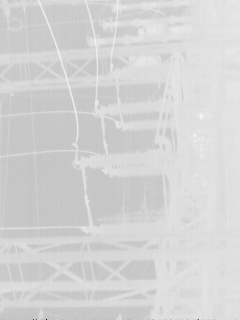

In [120]:
to_pil_image(normalize_image(img))

## Apply classif

In [34]:
def gen_batches(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

TODO: prep data in parallel

In [52]:
%%time

# predict labels

_pred, _pred_proba, _pred_class = [], [], []
_inputs, _targets = [], []
_filenames = []

bs = 512
for filenames in tqdm(gen_batches(imgs_idx, bs), total=len(imgs_idx)//bs):
    inputs = torch.stack([
        transformer(
            to_pil_image(
                normalize_image(
                    pkl_load(Path(path+img)))))
        for img in filenames])
    
    if is_cuda:
        inputs = inputs.cuda()
    
    pred = model(inputs).softmax(1)
    pred_proba, pred_class = pred.max(1)
    
    if is_cuda:
        inputs = inputs.cpu()
        pred, pred_proba, pred_class = pred.cpu(), pred_proba.cpu(), pred_class.cpu()
        
    _pred.append(pred)
    _pred_proba.append(pred_proba)
    _pred_class.append(pred_class)
    _inputs.append(inputs)
    _filenames.append(filenames)

# squeeezing
pred = torch.cat(_pred)
pred_proba = torch.cat(_pred_proba)
pred_class = torch.cat(_pred_class)
inputs = torch.cat(_inputs)
filenames = flatten(_filenames)

17it [10:15, 36.21s/it]                        


CPU times: user 2min 5s, sys: 16.4 s, total: 2min 21s
Wall time: 10min 17s


In [58]:
_pred = np.array([dataset.decode_label(x) for x in pred_class])

In [79]:
_pred_defect = np.where(_pred == 1)
results = [(img_name.replace("|", "/").replace('.sav', ''), round(proba.item(), 4))
           for img_name, proba
           in zip(np.array(filenames)[_pred_defect], pred_proba[_pred_defect])]
results = (pd
           .DataFrame(results, columns=['file_path', 'defect_proba'])
           .set_index('file_path')
           .sort_values('defect_proba', ascending=False))
results.head()

defect_proba
file_path                               
Термо ПС/Осташино/T03633IR        0.9998
Термо ПС/Доробино/T02881IR        0.9953
Термо ПС/Залесная/T02821IR        0.9947
Термо ПС/Малахово/T04658IR        0.9935
Термо ПС/Дубна/T02373IR           0.9882

In [78]:
results.head(100).to_csv('top100_defect.csv')

## Select termo of interest

In [36]:
_patterns = ["T00129IR",
             "T00130IR",
             "T00131IR",
             "T00132IR",
             "T00887IR",
             "T00888IR",
             "T06521IR",
             "T06522IR",
             "T06523IR",
             "T06524IR", ]

In [89]:
_patterns = ['T03834IR',
             'T05232IR',
             'T05233IR',
             'T06984IR',
             'T06983IR', ]

In [90]:
imgs_filt = [img
             for img in imgs_idx
             if any([pat in img for pat in _patterns])]

In [91]:
imgs_filt

['Термо ПС|Болоховская|T05233IR.sav',
 'Термо ПС|Болоховская|T05232IR.sav',
 'Термо ПС|Болоховская|T06983IR.sav',
 'Термо ПС|Болоховская|T03834IR.sav',
 'Термо ПС|Болоховская|T06984IR.sav']

In [92]:
from torchvision.transforms.functional import to_tensor
from pathlib import Path

In [93]:
# с трансформером

loaded_imgs = torch.stack([
    transformer(
        to_pil_image(
            normalize_image(
                pkl_load(Path(path+img)))))
    for img in imgs_filt])
loaded_imgs.shape

torch.Size([5, 1, 224, 224])

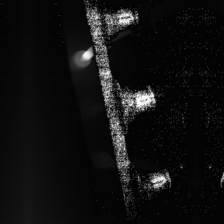

In [94]:
to_pil_image(loaded_imgs[0])

In [124]:
# для классификации

output = model(loaded_imgs.cuda())
pred_proba, pred_class = output.softmax(1).max(1)
[(dataset.decode_label(x), round(y.item(), 4)) for x,y in zip(pred_class, pred_proba)]

[(0, 0.5685), (1, 0.6703), (1, 0.7447), (1, 0.7277), (1, 0.5213)]

In [96]:
output = model(loaded_imgs.cuda())
pred_proba, pred_class = output.softmax(1).topk(5)

_df_eci = df_eci.copy()
result = pd.DataFrame()
for _img_name, _proba, _class in zip(imgs_filt, pred_proba, pred_class):
    _locs = [dataset.decode_label(p.item()) for p in _class]
    _df_eci.loc[_locs, 'proba'] = _proba.cpu().squeeze().numpy()
    _tmp = _df_eci.loc[_locs].reset_index().copy()
    _tmp['image_path'] = _img_name.replace('|', '/').replace('.sav', '')
    result = result.append(_tmp)

result.head()

NameError: name 'df_eci' is not defined

In [138]:
result.to_csv('./tmp.csv', sep=';')

# Pretrained models adoptation

In [150]:
from torchvision.models import resnet18
from torch import nn

In [194]:
resnet = resnet18(pretrained=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [195]:
resnet.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [196]:
resnet.conv1.weight.shape

torch.Size([64, 3, 7, 7])

In [197]:
resnet.conv1.weight

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

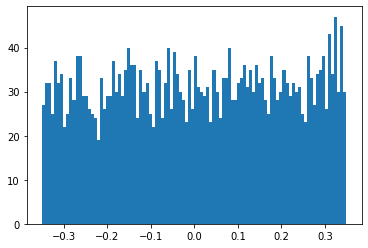

In [210]:
plt.hist(resnet.conv1.weight.detach().flatten(), bins=100);

In [206]:
conv = resnet.conv1
resnet.conv1 = torch.nn.Conv2d(1, conv.out_channels, conv.kernel_size, conv.stride, conv.padding,
                                   conv.dilation, conv.groups, conv.bias, conv.padding_mode)


In [213]:
nn.init.xavier_normal_(resnet.conv1.weight)

Parameter containing:
tensor([[[[ 5.1142e-02, -1.7516e-02, -2.2706e-02,  ...,  8.8622e-03,
            2.3389e-02,  3.9373e-03],
          [-2.5175e-03,  1.5183e-02, -9.8285e-03,  ...,  1.0240e-02,
           -1.0920e-02,  5.6569e-03],
          [ 2.1895e-02,  3.4969e-02, -7.0131e-03,  ...,  1.7211e-02,
           -5.6129e-03, -9.0409e-03],
          ...,
          [-6.5605e-03,  2.1293e-02, -2.3870e-02,  ...,  1.4148e-02,
           -4.4458e-02,  1.9946e-02],
          [-5.0428e-02,  2.9449e-02, -1.5390e-02,  ..., -1.0889e-03,
           -6.0033e-02, -4.3920e-02],
          [ 8.7366e-03, -1.2286e-02, -1.6791e-02,  ...,  2.9144e-02,
            1.8640e-02, -1.9451e-03]]],


        [[[ 4.4673e-03, -2.3735e-02,  2.7139e-02,  ...,  1.0931e-02,
            7.6945e-02,  2.8408e-02],
          [-1.9073e-02,  2.4887e-02, -1.5463e-02,  ..., -4.1903e-02,
            3.0652e-02, -6.3326e-03],
          [ 3.7039e-02, -1.8857e-02,  3.8389e-02,  ..., -1.2739e-02,
            1.8341e-03, -5.7370e-0

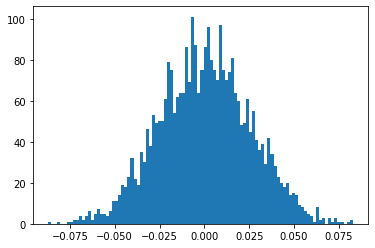

In [214]:
plt.hist(resnet.conv1.weight.detach().flatten(), bins=100);